## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import re
from tqdm import tqdm
from random import sample, seed
from time import sleep

seed(42)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
device

'cuda:0'

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [3]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


In [5]:
len(set(text))

38

### Data loading: "Евгений Онегин"


In [6]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    russian_text = iofile.readlines()
    
russian_text = [x.replace('\t\t', '') for x in russian_text]

--2021-12-23 07:53:47--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.3’

onegin.txt.3        100%[===================>] 256,37K   135KB/s    in 1,9s    

2021-12-23 07:53:50 (135 KB/s) - ‘onegin.txt.3’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [7]:
# Join all the strings into one and lowercase it
# Put result into variable text.

russian_text = ''.join(russian_text).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [8]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [9]:
token_to_idx = {char: idx for idx, char in enumerate(tokens)}
idx_to_token = {idx: char for idx, char in enumerate(tokens)}

MAX_LENGTH = 100

sequences = text.split('\n')
sequences = [seq.strip(' ') + '\n' for seq in sequences]
all_sequences = ''.join(sequences)
sequences = []

for i in range(len(all_sequences) - MAX_LENGTH):
    sequences.append(all_sequences[i:(i + MAX_LENGTH)])

assert len(set(map(len, sequences))) == 1, (
    "All sequences must be same length"
)

In [10]:
print(f"MAX_LENGTH: {MAX_LENGTH}")
sequences[:10]

MAX_LENGTH: 100


["from fairest creatures we desire increase,\nthat thereby beauty's rose might never die,\nbut as the ri",
 "rom fairest creatures we desire increase,\nthat thereby beauty's rose might never die,\nbut as the rip",
 "om fairest creatures we desire increase,\nthat thereby beauty's rose might never die,\nbut as the ripe",
 "m fairest creatures we desire increase,\nthat thereby beauty's rose might never die,\nbut as the riper",
 " fairest creatures we desire increase,\nthat thereby beauty's rose might never die,\nbut as the riper ",
 "fairest creatures we desire increase,\nthat thereby beauty's rose might never die,\nbut as the riper s",
 "airest creatures we desire increase,\nthat thereby beauty's rose might never die,\nbut as the riper sh",
 "irest creatures we desire increase,\nthat thereby beauty's rose might never die,\nbut as the riper sho",
 "rest creatures we desire increase,\nthat thereby beauty's rose might never die,\nbut as the riper shou",
 "est creatures we desire increase,\n

In [11]:
def to_matrix(sequences, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = MAX_LENGTH
    seq_ix = np.zeros([len(sequences), max_len], dtype)

    for i, seq in enumerate(sequences):
        line_ix = [token_to_idx[c] for c in seq]
        seq_ix[i, :] = line_ix
        
    if not batch_first:
        names_ix = np.transpose(seq_ix)

    return seq_ix

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

Принято решение использовать слой Embedding

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [12]:
class VanilaRNN(nn.Module):
    
    def __init__(self, num_tokens=len(tokens), embedding_size=64, rnn_num_units=512):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        x_emb = self.embedding(x).to(device)
        h_prev = torch.tensor(h_prev).to(device)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        logits = self.rnn_to_logits(h_next)
        
        return h_next, nn.functional.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)
    
def rnn_loop(model, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = model.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = model(x_t, hid_state)
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

def generate_text(model, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hid_state = model.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = model(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = model(x_sequence[:, -1], hid_state.to(device))
        p_next = nn.functional.softmax(logp_next.detach() / temperature, dim=-1).data.detach().to('cpu').numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(dict_size, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.to('cpu').numpy()[0]])

In [13]:
dict_size = len(token_to_idx)

model_rnn = VanilaRNN()
model_rnn = model_rnn.to(device)

n_epochs = 50000
lr = 0.01

loss_func = nn.NLLLoss()
optimizer = torch.optim.SGD(model_rnn.parameters(), lr=lr)

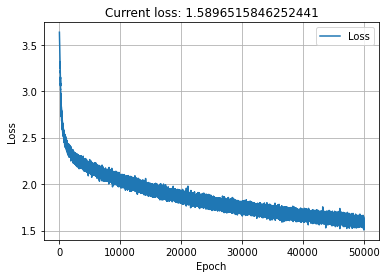

100%|██████████| 50000/50000 [31:21<00:00, 26.58it/s]

Test text: ' there are sould doth to make when in the live the elling my love the words the world deserving mand'


In [14]:
train_loss_lst = []
plot_tick = 100

for i in tqdm(range(n_epochs)):
    batch_ix = to_matrix(sample(sequences, 32))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)
    
    logp_seq = rnn_loop(model_rnn, batch_ix)
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = loss_func(predictions_logp.reshape(-1, dict_size), actual_next_tokens.reshape(-1))
    
    # train with backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_loss_lst.append(loss.data.to('cpu').numpy())

    if (i + 1) % plot_tick == 0:
        clear_output(True)
        plt.plot(train_loss_lst, label='Loss')
        plt.grid()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f"Current loss: {np.mean(train_loss_lst[-plot_tick:])}")
        plt.show()
        
        test_text = generate_text(model_rnn, seed_phrase=' there are', max_length=MAX_LENGTH, temperature=0.5)
        print(f"Test text: '{test_text}'")

assert np.mean(train_loss_lst[:10]) > np.mean(train_loss_lst[-10:]), "RNN didn't converge."

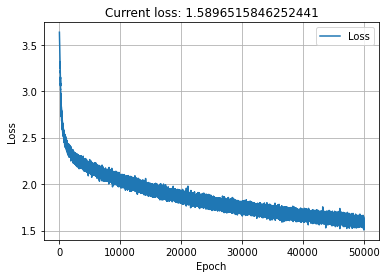

In [15]:
plt.plot(train_loss_lst, label='Loss')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f"Current loss: {np.mean(train_loss_lst[-plot_tick:])}")
plt.show()

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [16]:
seed_text = sequences[0][:13]
print('Real text:\n')
print(sequences[0])
seed_text = ''.join(seed_text)
print(f'text seed: {seed_text}')

Real text:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the ri
text seed: from fairest 


In [17]:
length = 500
temperature_lst = [0.1, 0.2, 0.5, 1.0, 2.0]
for temperature in temperature_lst:
    print(f"Temperature: {temperature}\nText:\n")
    print(generate_text(model_rnn, seed_text, length, temperature))
    print()

Temperature: 0.1
Text:

from fairest the world the state,
and the stranger thee the world the state the world the world the stand the worth the world the state my love the world the stand the stare the world the stranger the stare the world my love the world the stand the stare the worth the stand the state,
and the seem the world the stranger the state of the world my love the world the stranger the state of the state the world the stranger the stand the stand the stand the stranger the stare the world the stare the w

Temperature: 0.2
Text:



/home/aslan/anaconda3/envs/dl_env/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


from fairest the strange of the world the state where is the that the start the seem the proud that the world the worth thee the start the summer should the strends of the world the stand the streasure the stand the stranger that thou art the world the beauty shall thee that the world the const the world thee that which in the stand the strange the world the stall the should the strange the world thee in the stand the stranger thee the world the strange the start the world in the stand the world

Temperature: 0.5
Text:

from fairest the resare the every brow,
she true the come with me thy beauty that with thee the such live in the belf the chall chilst of thy sweet make hath me breature the can i hope doth all the with they shalt the our love shall the prowing thee the light to my heart hath the preater shall thee i am thee and beauty me blace the world be days if thy be to spents he as the sweet proud;
but thou art the store,
that place the doth that lives my heart thy mure the world 

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [18]:
class LSTM(nn.Module):
    
    def __init__(self, num_tokens=len(token_to_idx), embedding_size=64, hidden_size=1024):
        super(self.__class__,self).__init__()
        self.num_units = hidden_size
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.linear_1 = nn.Linear(embedding_size + hidden_size, hidden_size)
        self.linear_2 = nn.Linear(embedding_size + hidden_size, hidden_size)
        self.linear_3 = nn.Linear(embedding_size + hidden_size, hidden_size)
        self.linear_4 = nn.Linear(embedding_size + hidden_size, hidden_size)
        self.rnn_to_logits = nn.Linear(hidden_size, num_tokens)
        
    def forward(self, x, h_prev, c_prev):
        """
        This method computes h_next, c_next from (x, h_prev, c_prev) and log P(x_next | h_next, c_prev)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        :param c_prev: previous memory state, containing matrix [batch, rnn_num_units] of float32
        """
        x_emb = self.embedding(x).to(device)
        h_prev = torch.tensor(h_prev).to(device)
        c_prev = torch.tensor(c_prev).to(device)
        # c_prev = torch.tensor(c_prev).to(device)
        # x_and_c = torch.cat([x_emb, c_prev], dim=-1)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        c_next = self.linear_1(x_and_h)
        c_next = torch.sigmoid(c_next)
        c_next = torch.mul(c_prev, c_next)
        c_next_2 = self.linear_2(x_and_h)
        c_next_2 = torch.sigmoid(c_next_2)
        c_next_3 = self.linear_3(x_and_h)
        c_next_3 = torch.tanh(c_next_3)
        c_next_3 = torch.mul(c_next_2, c_next_3)
        c_next = torch.add(c_next, c_next_3)
        
        h_next = self.linear_4(x_and_h)
        h_next = torch.sigmoid(h_next)
        h_next_1 = torch.tanh(c_next)
        h_next = torch.mul(h_next, h_next_1)
        
        assert h_next.size() == h_prev.size(), (
            f"h_prev: {h_prev.size()}, h_next: {h_next.size()}"
        )
        assert c_next.size() == c_prev.size(), (
            f"c_prev: {c_prev.size()}, c_next: {c_next.size()}"
        )
        
        logits = self.rnn_to_logits(h_next)
        logits = nn.functional.log_softmax(logits, -1)
        
        return h_next, c_next, logits
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)
    
def rnn_loop(model, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = model.initial_state(batch_size)
    c_state = model.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, c_state, logp_next = model(x_t, hid_state, c_state)
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

def generate_text(model, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hid_state = model.initial_state(batch_size=1)
    c_state = model.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, c_state, _ = model(x_sequence[:, i], hid_state, c_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, c_state, logp_next = model(x_sequence[:, -1], hid_state, c_state)
        p_next = nn.functional.softmax(logp_next.detach() / temperature, dim=-1).data.detach().to('cpu').numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(dict_size, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.to('cpu').numpy()[0]])

In [19]:
dict_size = len(token_to_idx)
embedding_size = dict_size

model_lstm = LSTM()
model_lstm = model_lstm.to(device)

n_epochs = 150000
lr=0.01

loss_func = nn.NLLLoss()
optimizer = torch.optim.SGD(model_lstm.parameters(), lr=lr)

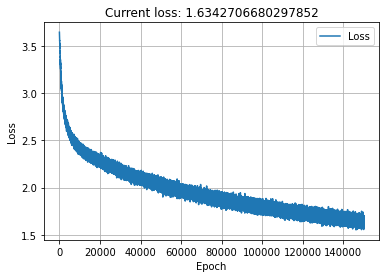

100%|██████████| 150000/150000 [3:33:03<00:00, 11.73it/s]

Test text: ' there are that the soy light the worth say in the beauty for my love to pour my sould that of the t'


In [20]:
train_loss_lst = []
plot_tick = 100

for i in tqdm(range(n_epochs)):
    batch_ix = to_matrix(sample(sequences, 32))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)
    
    logp_seq = rnn_loop(model_lstm, batch_ix)
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = loss_func(predictions_logp.reshape(-1, dict_size), actual_next_tokens.reshape(-1))
    
    # train with backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_loss_lst.append(loss.data.to('cpu').numpy())

    if (i + 1) % plot_tick == 0:
        clear_output(True)
        plt.plot(train_loss_lst, label='Loss')
        plt.grid()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f"Current loss: {np.mean(train_loss_lst[-plot_tick:])}")
        plt.show()
        
        test_text = generate_text(model_lstm, seed_phrase=' there are', max_length=MAX_LENGTH, temperature=0.5)
        print(f"Test text: '{test_text}'")

assert np.mean(train_loss_lst[:10]) > np.mean(train_loss_lst[-10:]), "RNN didn't converge."

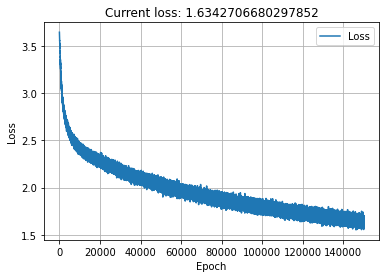

In [21]:
plt.plot(train_loss_lst, label='Loss')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f"Current loss: {np.mean(train_loss_lst[-100:])}")
plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [22]:
seed_text = sequences[0][:13]
print('Real text:\n')
print(sequences[0])
seed_text = ''.join(seed_text)
print(f'text seed: {seed_text}')

Real text:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the ri
text seed: from fairest 


In [23]:
length = 500
temperature_lst = [0.1, 0.2, 0.5, 1.0, 2.0]
for temperature in temperature_lst:
    print(f"Temperature: {temperature}\nText:\n")
    print(generate_text(model_lstm, seed_text, length, temperature))
    print()

Temperature: 0.1
Text:



/home/aslan/anaconda3/envs/dl_env/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/aslan/anaconda3/envs/dl_env/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


from fairest thou art the stant the worth the state the state the worth the summer the some the seem the seem the stant the stant thou art thou art the stant the stant the worth the worth the worth the some the see the worth the stant the stant the state the stant the see the state the worth the stant the worth the some the stant the stant the seem the stant the summer the stant the stant the stant the so the state thou art the stant the worth the state the state the state thou art the summer's 

Temperature: 0.2
Text:

from fairest the self the stant the stange the seem beauty the seem the worth the strange the worth the worth stant the seem the so in the stant the sour shall my love the strange thee the beauty the see thee the self the say the worth still the worth the some the seem the state the worth with the seem the prost the worth the stant the seem beauty of the strong the some the waster the world with the so forth the some the state the worth the stant the thou art the store 

Результат работы LSTM для temperature=0.5 получился достаточно неплохим. Особенно улучшились значение для temperature=0.2.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [24]:
# Saving and loading code here
RNN_PATH = os.path.join('models', 'torch_rnn.model')
LSTM_PATH = os.path.join('models', 'torch_lstm.model')

In [28]:
torch.save(model_rnn.state_dict(), RNN_PATH)
torch.save(model_lstm.state_dict(), LSTM_PATH)

In [29]:
model_rnn = VanilaRNN()
model_rnn.load_state_dict(torch.load(RNN_PATH))

model_lstm = LSTM()
model_lstm.load_state_dict(torch.load(LSTM_PATH))

<All keys matched successfully>

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)